GitHub Link: https://github.com/muhammetbolat/ITU_ComputerVision_HW2

I uploaded the codes in the repository. I'm trying to explain what I did belows.

In [371]:
import numpy as np
import pandas as pd
import cv2
import collections
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import filters
from skimage import util
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import MeanShift, estimate_bandwidth
import warnings
warnings.filterwarnings("ignore")

# A.) PRE-PROCESSING

### 1. Download the “Sunny Lake” image.

I downloaded the 'SunnyLake.bmp' image in the same directory.

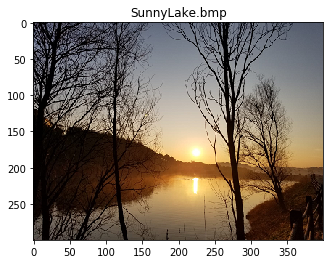

In [372]:
imageName = 'SunnyLake.bmp'
image = plt.imread(imageName)
plt.figure('SunnyLake')
plt.title('SunnyLake.bmp')
plt.imshow(image)
#plt.savefig('SunnyLake.jpg')

In [373]:
width, height, original_dimension = image.shape

### 2.) Create a dataframes from image.

<b>df_1</b>: Vector which have RGB pixel values and their location on the image.

<b>df_2</b>: Vector which have only image RGB pixels.

<b>df_3</b>: Vector which have only grayscale pixels and their location on the image.

<b>df_4</b>: Vector which have only grayscale pixels.

In [454]:
index = pd.MultiIndex.from_product(
    (*map(range, image.shape[:2]), ('r', 'g', 'b')),
    names=('row', 'col', None))

df_1 = pd.Series(image.flatten(), index=index)
df_1 = df_1.unstack()
df_1 = df_1.reset_index().reindex(columns=['col', 'row', 'r', 'g', 'b'])
df_1.head(3)

,col,row,r,g,b
0,0,0,2,2,4
1,1,0,1,1,0
2,2,0,25,25,27


In [455]:
df_2 = df_1[['r', 'g', 'b']]

df_2.head(3)

,r,g,b
0,2,2,4
1,1,1,0
2,25,25,27


In [456]:
df_3 = df_1[['col', 'row']]
df_3['grayscale'] = df_1[['r', 'g', 'b']].mean(axis = 1)
df_3.head(3)

,col,row,grayscale
0,0,0,2.666667
1,1,0,0.666667
2,2,0,25.666667


In [377]:
df_4 =  df_1[['r', 'g', 'b']].mean(axis = 1)
df_4.head()

0     2.666667
1     0.666667
2    25.666667
3    61.333333
4    75.333333
dtype: float64

### 2. Normalize pixels to 0-1

Sklearn reads images dtype as int 8 bits. We need to convert it to floating point numbers. Then all pixels are dividied by 255. It will be set 0-1 range.

In [378]:
nd_1 = df_1.values.astype(np.float32)
nd_1[:, 0] = nd_1[:, 0] / (nd_1[:, 0].max() + 1)
nd_1[:, 1] = nd_1[:, 1] / (nd_1[:, 1].max() + 1)
nd_1[:, 2:] = nd_1[:, 2:] / 255

In [379]:
nd_2 = df_2.astype(np.float64) / 255

In [380]:
nd_3 = df_3.values
nd_3[:, 0] = nd_3[:, 0] / (nd_3[:, 0].max() + 1)
nd_3[:, 1] = nd_3[:, 1] / (nd_3[:, 1].max() + 1)
nd_3[:, 2] = nd_3[:, 2] / 255

In [381]:
nd_3

array([[0.        , 0.        , 0.01045752],
       [0.0025    , 0.        , 0.00261438],
       [0.005     , 0.        , 0.10065359],
       ...,
       [0.9925    , 0.99666667, 0.06405229],
       [0.995     , 0.99666667, 0.08366013],
       [0.9975    , 0.99666667, 0.10196078]])

In [382]:
nd_4 = df_4 / 255

In [383]:
nd_1.shape, nd_2.shape, nd_3.shape, nd_4.shape

((120000, 5), (120000, 3), (120000, 3), (120000,))

# B.) K-MEANS ALGORITHM

### 1.Find the best cluster numbers using Elbow method.

In [212]:
total_inertias_1 = [KMeans(n_clusters=i).fit(nd_1).inertia_ for i in range(1, 10)]
total_inertias_2 = [KMeans(n_clusters=i).fit(nd_2).inertia_ for i in range(1, 10)]
total_inertias_3 = [KMeans(n_clusters=i).fit(nd_3).inertia_ for i in range(1, 10)]
total_inertias_4 = [KMeans(n_clusters=i).fit(nd_4.values.reshape(-1, 1)).inertia_ for i in range(1, 10)]

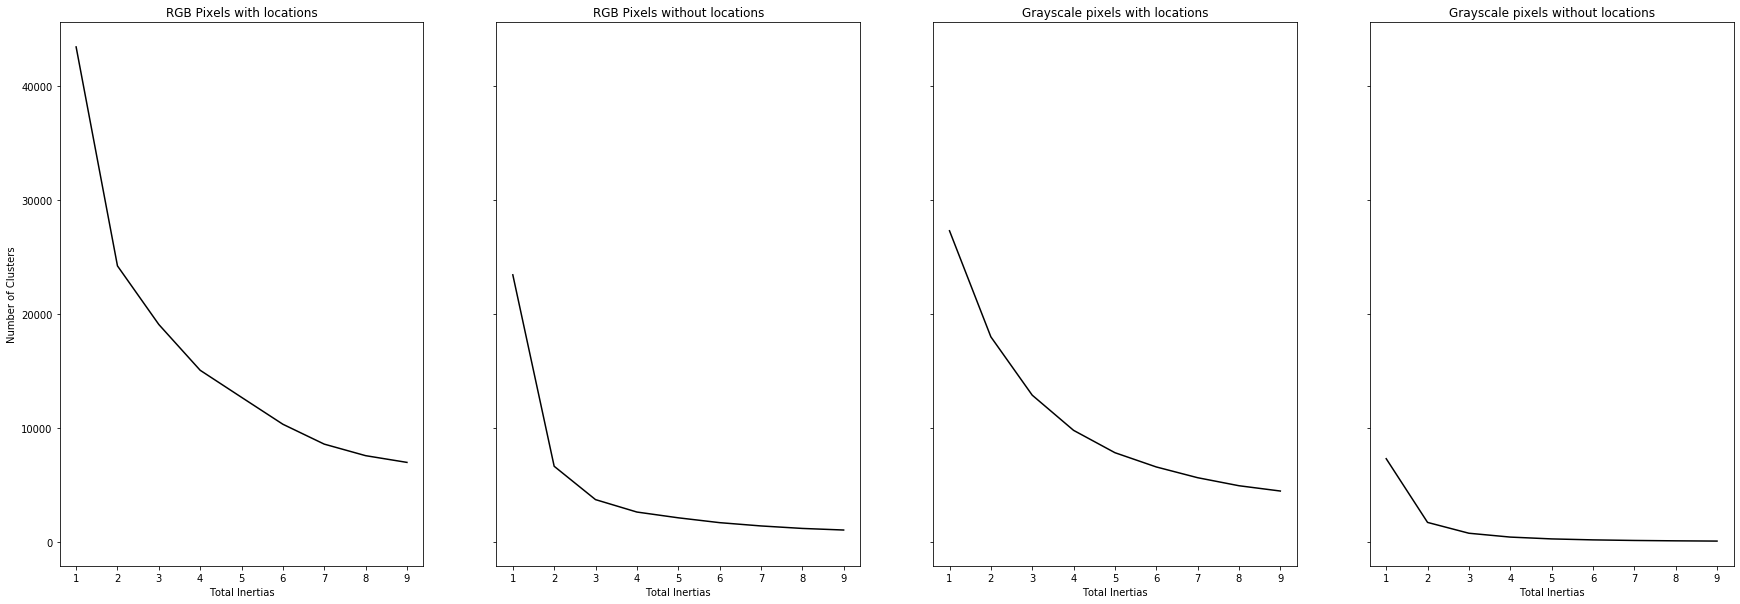

In [213]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex='col', sharey='row', figsize=(30,10))

ax1.plot(range(1, 10), total_inertias_1, c='black')
ax1.set(xlabel='Total Inertias', ylabel='Number of Clusters', title='RGB Pixels with locations')

ax2.plot(range(1, 10), total_inertias_2, c='black')
ax2.set(xlabel='Total Inertias', title='RGB Pixels without locations')

ax3.plot(range(1, 10), total_inertias_3, c='black')
ax3.set(xlabel='Total Inertias', title='Grayscale pixels with locations')

ax4.plot(range(1, 10), total_inertias_4, c='black')
ax4.set(xlabel='Total Inertias', title='Grayscale pixels without locations')
ax4.set

plt.show()

### 2. Elbow points are determined according to the graphics above.

As you can see above graphs, the best cluster number is 3.

In [443]:
n_cluster_1 = 10
n_cluster_2 = 11
n_cluster_3 = 11 #Grayscale pixels with locations
n_cluster_4 = 3 #Grayscale pixels without locations

### 3.Clustering

You can see how many time we wait for clustering.

In [426]:
%time km_1 = KMeans(n_clusters=n_cluster_1, random_state=0).fit(nd_1)

CPU times: user 9.54 s, sys: 1.51 s, total: 11.1 s
Wall time: 4.63 s


In [427]:
%time km_2 = KMeans(n_clusters=n_cluster_2, random_state=0).fit(nd_2)

CPU times: user 10.8 s, sys: 2.66 s, total: 13.5 s
Wall time: 6.71 s


In [428]:
%time km_3 = KMeans(n_clusters=n_cluster_3, random_state=0).fit(nd_3)

CPU times: user 8.88 s, sys: 1.95 s, total: 10.8 s
Wall time: 4.11 s


In [444]:
%time km_4 = KMeans(n_clusters=n_cluster_4, random_state=0).fit(nd_4.values.reshape(-1, 1))

CPU times: user 2.04 s, sys: 327 ms, total: 2.36 s
Wall time: 613 ms


recreate_image is coded due to recreate new image according to the results which come from Kmeans algorithm.

In [430]:
def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    try:
        d = codebook.shape[1]
    except IndexError:
        d = 1

    if d == 1:
        image = np.zeros((w, h))
    else:
        image = np.zeros((w, h, d))
    
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1

    return image

### 4.Showing the final images.

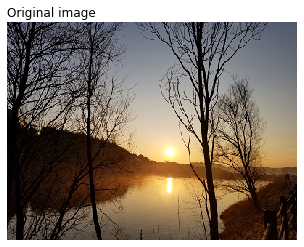

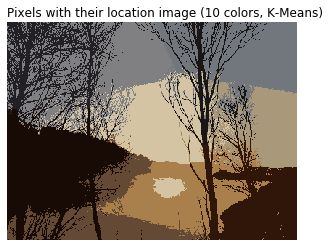

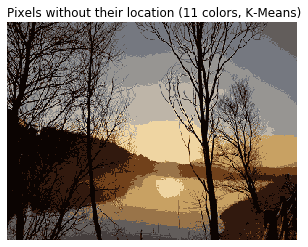

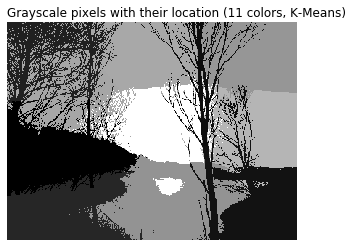

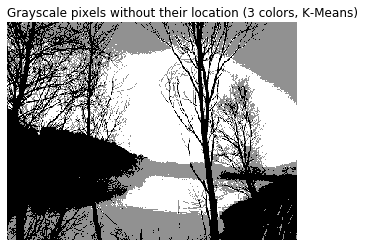

In [453]:
plt.figure(1)
plt.clf()
plt.axis('off')
plt.title('Original image', loc='left')
plt.imshow(image)


plt.figure(2)
plt.clf()
plt.axis('off')
plt.title('Pixels with their location image ({} colors, K-Means)'.format(n_cluster_1), loc='left')
plt.imshow(recreate_image(km_1.cluster_centers_[:, 2:], km_1.labels_, width, height));

plt.figure(3)
plt.clf()
plt.axis('off')
plt.title('Pixels without their location ({} colors, K-Means)'.format(n_cluster_2), loc='left')
plt.imshow(recreate_image(km_2.cluster_centers_, km_2.labels_, width, height));

plt.figure(4)
plt.clf()
plt.axis('off')
plt.title('Grayscale pixels with their location ({} colors, K-Means)'.format(n_cluster_3), loc='left')
plt.imshow(recreate_image(km_3.cluster_centers_[:, 2], km_3.labels_, width, height), cmap='gray');

plt.figure(5)
plt.clf()
plt.axis('off')
plt.title('Grayscale pixels without their location ({} colors, K-Means)'.format(n_cluster_4), loc='left')
plt.imshow(recreate_image(km_4.cluster_centers_, km_4.labels_, width, height), cmap='gray');

# C.) MEAN-SHIFT CLUSTERING

### 1. Calculate the best bandwith which is specified by feature vector.

In [386]:
bandwidth_1 = estimate_bandwidth(nd_1, quantile=.04, n_jobs=-1); bandwidth_1

0.23298278428525732

In [387]:
bandwidth_2 = estimate_bandwidth(nd_2, quantile=.04, n_jobs=-1); bandwidth_2

0.07890197160942992

In [388]:
bandwidth_3 = estimate_bandwidth(nd_3, quantile=.04, n_jobs=-1); bandwidth_3

0.18561836089009423

In [389]:
bandwidth_4 = estimate_bandwidth(np.reshape(nd_4.values, [-1, 1]), quantile=.004); bandwidth_4

0.0019921677559912826

### 2. Clustering

In [390]:
ms_1 = MeanShift(bandwidth = bandwidth_1 , n_jobs=-1, bin_seeding=True, cluster_all=True).fit(nd_1)

In [391]:
ms_2 = MeanShift(bandwidth = bandwidth_2 , n_jobs=-1, bin_seeding=True, cluster_all=True).fit(nd_2)

In [392]:
ms_3 = MeanShift(bandwidth = bandwidth_3 , n_jobs=-1, bin_seeding=True, cluster_all=True).fit(nd_3)

In [393]:
ms_4 = MeanShift(bandwidth = bandwidth_4 , n_jobs=-1, bin_seeding=True, cluster_all=True).fit(np.reshape(nd_4.values, [-1, 1]))

### 3. Showing the final images.

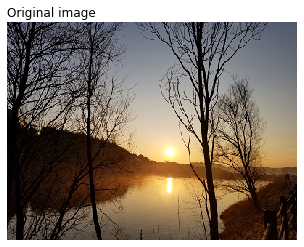

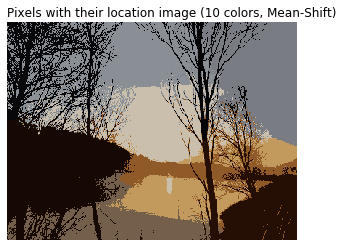

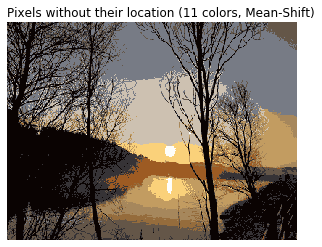

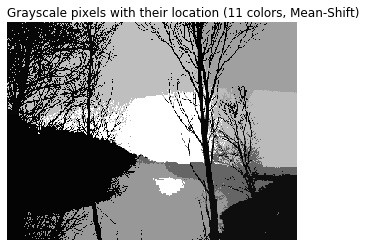

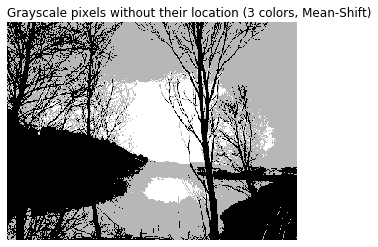

In [452]:
plt.figure(1)
plt.clf()
plt.axis('off')
plt.title('Original image', loc='left')
plt.imshow(image)

plt.figure(2)
plt.clf()
plt.axis('off')
plt.title('Pixels with their location image ({} colors, Mean-Shift)'.format(len(ms_1.cluster_centers_)), loc='left')
plt.imshow(recreate_image(ms_1.cluster_centers_[:, 2:], ms_1.labels_, width, height));

plt.figure(3)
plt.clf()
plt.axis('off')
plt.title('Pixels without their location ({} colors, Mean-Shift)'.format(len(ms_2.cluster_centers_)), loc='left')
plt.imshow(recreate_image(ms_2.cluster_centers_, ms_2.labels_, width, height));

plt.figure(4)
plt.clf()
plt.axis('off')
plt.title('Grayscale pixels with their location ({} colors, Mean-Shift)'.format(len(ms_3.cluster_centers_)), loc='left')
plt.imshow(recreate_image(ms_3.cluster_centers_[:, 2], ms_3.labels_, width, height), cmap='gray');

plt.figure(5)
plt.clf()
plt.axis('off')
plt.title('Grayscale pixels without their location ({} colors, Mean-Shift)'.format(len(ms_4.cluster_centers_)), loc='left')
plt.imshow(recreate_image(ms_4.cluster_centers_, ms_4.labels_, width, height), cmap='gray');

# D.) Evaluate Results

In [450]:
import matplotlib.pyplot as plt

def showDiff(im1, im2, cmap=None):
    plt.figure(1, figsize=(10,10))

    plt.subplot(211)
    plt.title('K-means')
    plt.imshow(im1, cmap=cmap)

    plt.subplot(212)
    plt.title('Mean-shift')
    plt.imshow(im2, cmap=cmap)
    
    plt.show()

### 1.) RGB pixels with locations

##### Cluster = 10

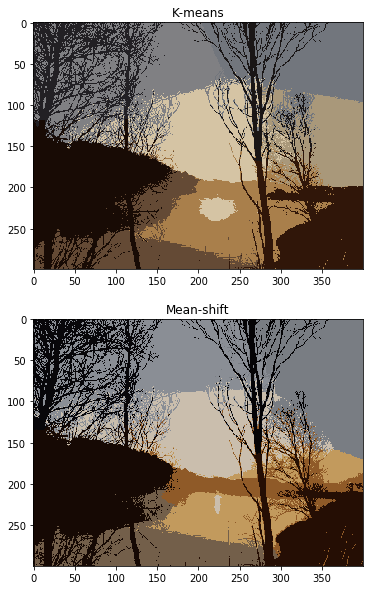

In [451]:
img_km = recreate_image(km_1.cluster_centers_[:, 2:], km_1.labels_, width, height)
img_ms = recreate_image(ms_1.cluster_centers_[:, 2:], ms_1.labels_, width, height)

showDiff(img_km, img_ms, cmap=None)

### 2.) RGB pixels without locations

##### Cluster = 11

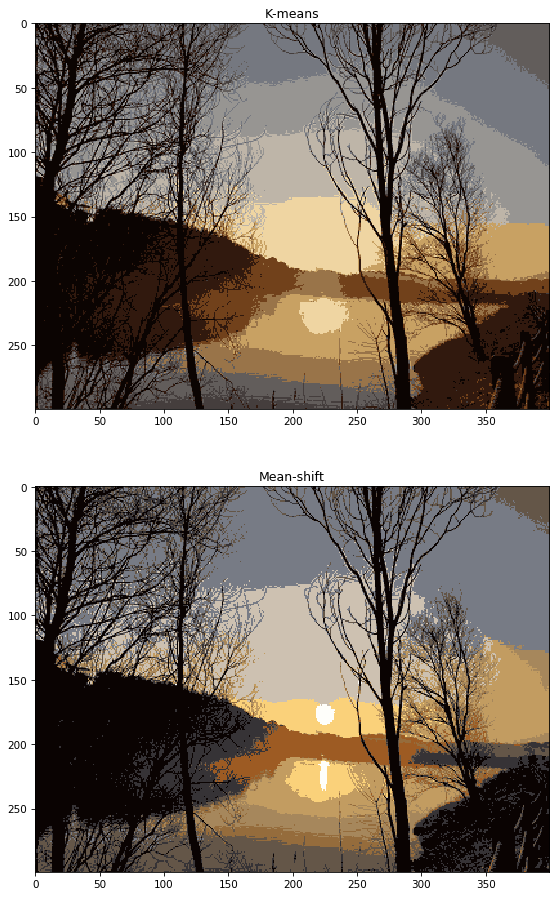

In [440]:
img_km = recreate_image(km_2.cluster_centers_, km_2.labels_, width, height)
img_ms = recreate_image(ms_2.cluster_centers_, ms_2.labels_, width, height)

showDiff(img_km, img_ms, cmap=None)

### 3.) Grayscale pixels with locations

##### Cluster = 11

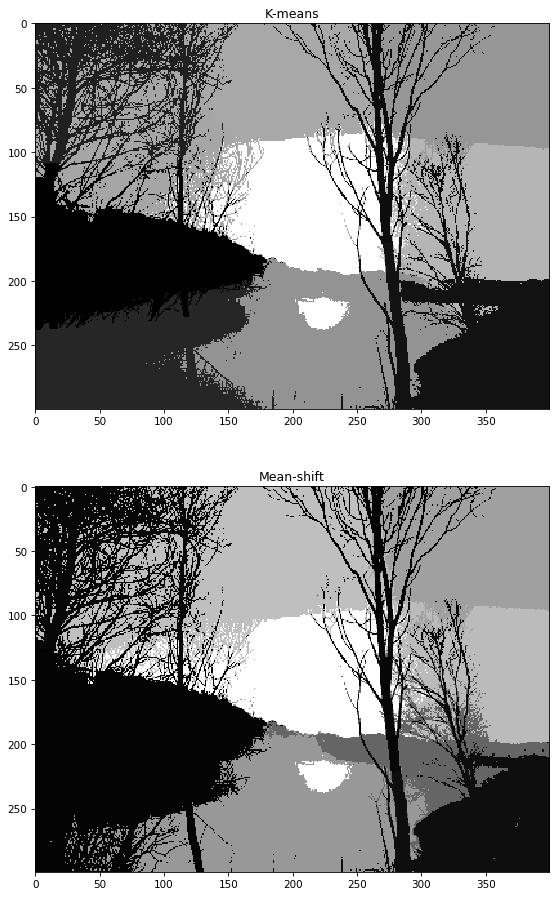

In [445]:
img_km = recreate_image(km_3.cluster_centers_[:, 2], km_3.labels_, width, height)
img_ms = recreate_image(ms_3.cluster_centers_[:, 2], ms_3.labels_, width, height)

showDiff(img_km, img_ms, cmap='gray')

### 4.) Grayscale pixels without locations

##### Cluster = 3

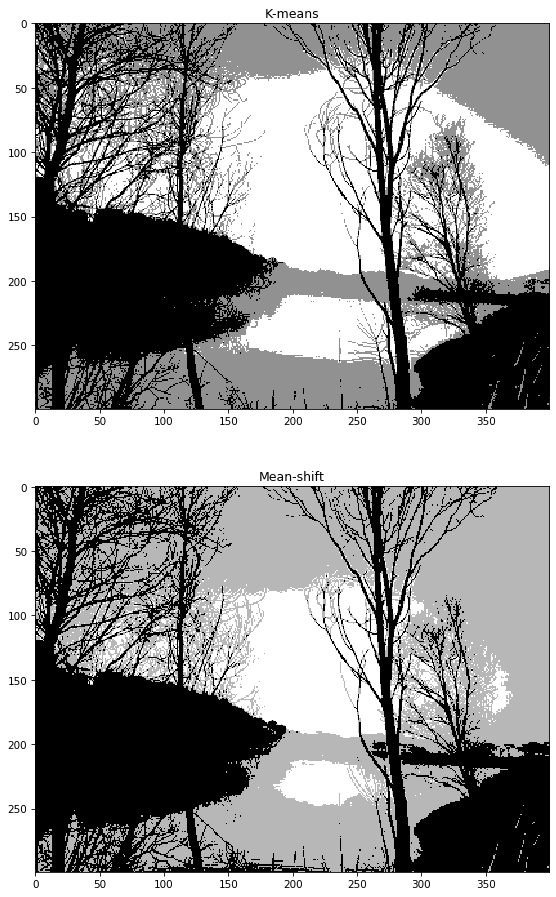

In [447]:
img_km = recreate_image(km_4.cluster_centers_, km_4.labels_, width, height)
img_ms = recreate_image(ms_4.cluster_centers_, ms_4.labels_, width, height)

showDiff(img_km, img_ms, cmap='gray')